In [78]:
from qiskit import QuantumCircuit, QuantumRegister, AncillaRegister, Aer, transpile, ClassicalRegister
from qiskit.visualization import plot_histogram, plot_bloch_multivector
from qiskit.quantum_info import Statevector
import numpy as np

# Check circuit

This first circuit, is used to get the results from the input.
It works using the Bernstein Vazirani circuit, which has a hidden string inside an oracle and if the correct input is given, then the result will be 11111...1 (N times) 

In [37]:
class Check:
    def __init__(self, *args):
        self.total_data_qubits = len(args)
        self.total_qubits = self.total_data_qubits+1
        
        self.phase_qubit = AncillaRegister(1, name="ancilla")
        self.circuit = QuantumCircuit(self.phase_qubit, *args)
        
        self.circuit_measurement = QuantumCircuit(self.total_qubits, self.total_data_qubits)
        self.circuit_measurement.measure(range(1, self.total_qubits), range(self.total_data_qubits))
        
    def add_input(self, bit_string):
        assert len(bit_string) == self.total_data_qubits, "Different amount of registers" 
        
        bit_string = self.parse_bit_string(bit_string)
    
        for qubit, bit in enumerate(bit_string):
            if(bit == '1'):
                self.circuit.x(qubit+1)
        self.add_barrier()
        
    def parse_bit_string(self, bit_string):
        return bit_string[::-1]
        
    def add_barrier(self):
        self.circuit.barrier()
    
    def prepare(self, bit_string, show_oracle=False, show_state_vector=False):
        self.add_oracle(bit_string, show_oracle)
        if(show_state_vector):
            self.show_state_vector()
            
    def add_oracle(self, bit_string, show_oracle):
        assert len(bit_string) <= self.total_data_qubits, "Different amount of registers" 
        
        bit_string = self.parse_bit_string(bit_string)
        qubits_iterator = range(self.total_qubits)
        
        oracle = QuantumCircuit(self.total_qubits, name="Oracle")
        
        oracle.x(0)
        oracle.h(qubits_iterator)
        
        for qubit, bit in enumerate(bit_string): 
            if(bit == '0'):
                oracle.cx(qubit+1, 0)
                
        oracle.h(qubits_iterator)
        
        if(show_oracle): 
            display(oracle.draw('mpl'))
        
        self.circuit.append(oracle, qubits_iterator)
        
    def show_state_vector(self):
        display(Statevector(self.circuit).draw('latex'))
        
    def add_measurement(self):
        self.circuit.compose(self.circuit_measurement, inplace=True)
    
    def measure(self, backend=Aer.get_backend("aer_simulator"), shots=1000):
        transpiled_circuit = transpile(self.circuit, backend)
        results = backend.run(transpiled_circuit, shots=shots).result().get_counts()
        display(plot_histogram(results))
        return {'results':results, 'shots':shots}
    
    def show(self):
        display(self.circuit.draw("mpl"))
        
    def get_circuit(self):
        return self.circuit
        

In [4]:
all_documents = QuantumRegister(1, name="documents")
false_info = QuantumRegister(1, name="falsification")
wanted = QuantumRegister(1, name="wanted")
bribe = QuantumRegister(1, name="bribe")

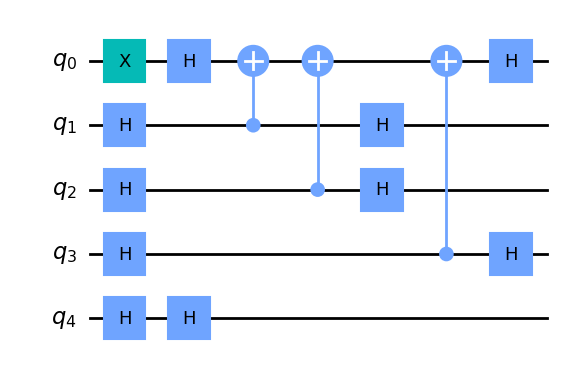

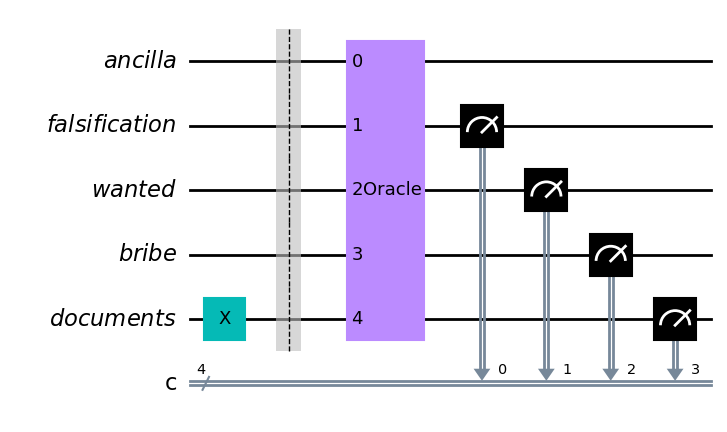

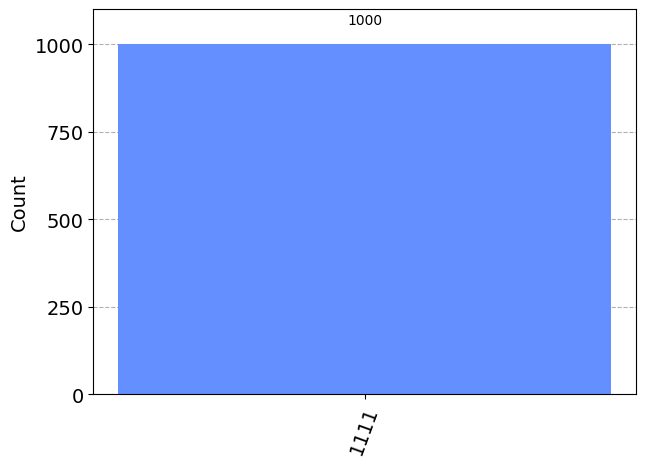

In [38]:
data = [false_info, wanted, bribe, all_documents]
checker = Check(*data)
checker.add_input("1000")
checker.prepare(bit_string="1000", show_oracle=True)
checker.add_measurement()
checker.show()
measurement_result = checker.measure()

In [8]:
total_shots = measurement_result['shots']
result = measurement_result['results']

In [9]:
def show_results(shots, result):
    get_percentage = lambda total, x: (x/total)*100
    ordered_result = dict(sorted(result.items(), key=lambda item: item[1], reverse=True))
    
    if(not '0' in list(ordered_result.keys())[0]):
        print('Recieved the correct result!!!')
    else:
        print('The result is Incorrect!!!')        
    
    print('-'*50)
    
    print("string - total - percentage")
    for bit_string, total in list(ordered_result.items()):
        print(f'{bit_string}     {total}    {int(get_percentage(shots, total))}%')

In [10]:
show_results(total_shots, result)

Recieved the correct result!!!
--------------------------------------------------
string - total - percentage
1111     1000    100%


In [41]:
from qiskit_ibm_provider import IBMProvider
import os
from dotenv import load_dotenv
load_dotenv()

IBMProvider.save_account(token=os.getenv('IBM_API_TOKEN'), overwrite=True)

In [42]:
provider = IBMProvider()
backend = provider.get_backend('ibmq_lima')

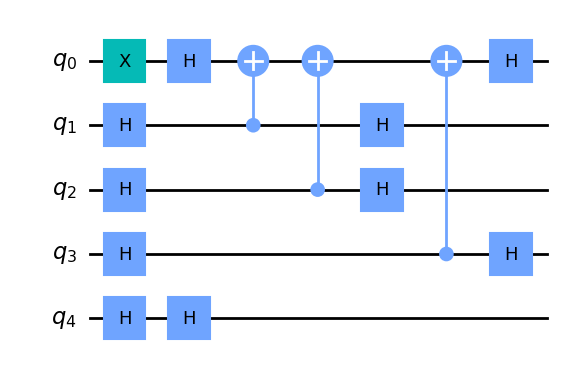

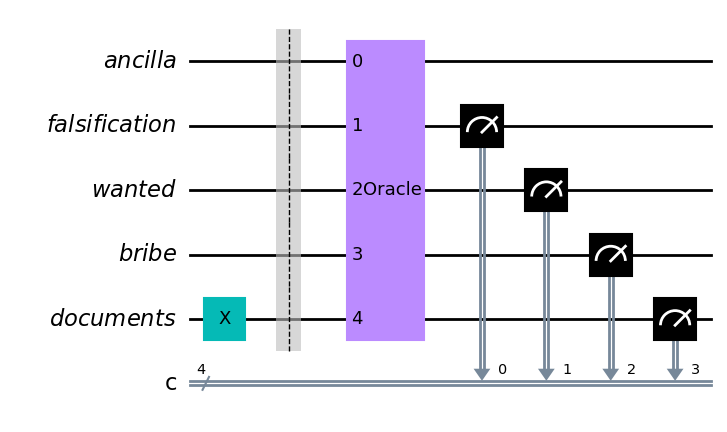

NameError: name 'backend' is not defined

In [39]:
data = [false_info, wanted, bribe, all_documents]
checker = Check(*data)
checker.add_input("1000")
checker.prepare(bit_string="1000", show_oracle=True)
checker.add_measurement()
checker.show()
measurement_result = checker.measure(backend=backend)

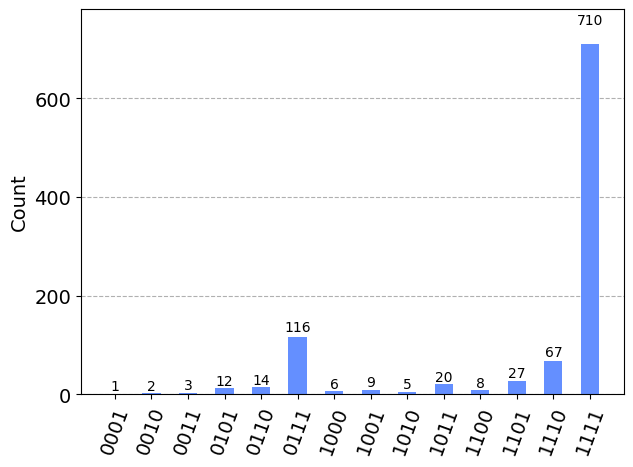

Recieved the correct result!!!
--------------------------------------------------
string - total - percentage
1111     710    71%
0111     116    11%
1110     67    6%
1101     27    2%
1011     20    2%
0110     14    1%
0101     12    1%
1001     9    0%
1100     8    0%
1000     6    0%
1010     5    0%
0011     3    0%
0010     2    0%
0001     1    0%


In [22]:
job_id = ''
job = provider.backend.retrieve_job(job_id)
result = job.result().get_counts()
display(plot_histogram(result))
show_results(1000, result)

---

# Generate data

Now, we have here the algorithm to generate the input data (or, if you prefer, the entrance data), which will be used be the Check algorithm.
It's based on Bloch sphere rotations and, roughly, we embed the probabilities to get the state $|1⟩$ using this equation:

> $ θ = \arcsin {\sqrt {b} \over 10} * 2 $

where $b$ is the percentage of probability to get $|1⟩$.

With $θ$ we can embed this probability using a $RY$ rotate.


In [14]:
def get_theta(B):
    return np.arcsin(B) * 2

In [12]:
def show_stats(shots, result):
    get_percentage = lambda total, x: (x/total)*100
    ordered_result = dict(sorted(result.items(), key=lambda item: item[1], reverse=True))
    
    print("string - total - percentage")
    for bit_string, total in list(ordered_result.items()):
        print(f'{bit_string}     {total}    {int(get_percentage(shots, total))}%')

## Documents
70% false and 30% true

## False info
60% false and 40% true

## Wanted
95% false and 5% true

## Bribe
90% false and 10% true

In [15]:
#a = cos(theta/2)
#B = e^(i phi) sin(theta/2)

qubits = ["all_documents", "false_info", "wanted", "bribe"]
percentages_of_true = [30, 40, 5, 10]

thetas = {}

for qubit, percentage in zip(qubits, percentages_of_true):
    B = np.sqrt(percentage)/10
    theta = get_theta(B)
    a = np.cos(theta/2)
    
    thetas[qubit] = theta
    
    print('-'*50)
    print(qubit.upper())
    print(f'theta: {theta}')
    print(f'a --> {a}')
    print(f'B --> {B}')
    print(f'a+B prob --> {a**2+B**2}')

--------------------------------------------------
ALL_DOCUMENTS
theta: 1.1592794807274085
a --> 0.8366600265340756
B --> 0.5477225575051661
a+B prob --> 1.0
--------------------------------------------------
FALSE_INFO
theta: 1.369438406004566
a --> 0.7745966692414834
B --> 0.6324555320336759
a+B prob --> 1.0
--------------------------------------------------
WANTED
theta: 0.4510268117962625
a --> 0.9746794344808963
B --> 0.223606797749979
a+B prob --> 0.9999999999999999
--------------------------------------------------
BRIBE
theta: 0.6435011087932844
a --> 0.9486832980505138
B --> 0.31622776601683794
a+B prob --> 0.9999999999999999


In [16]:
def test_probabilities(circuit):
    display(Statevector(circuit).draw('latex'))
    display(plot_bloch_multivector(circuit))
    circuit.measure_all()
    measurement_result = Aer.get_backend('aer_simulator').run(circuit, shots=1000).result().get_counts()
    display(show_stats(1000, measurement_result))

--------------------------------------------------
ALL_DOCUMENTS
theta: 1.1592794807274085


<IPython.core.display.Latex object>

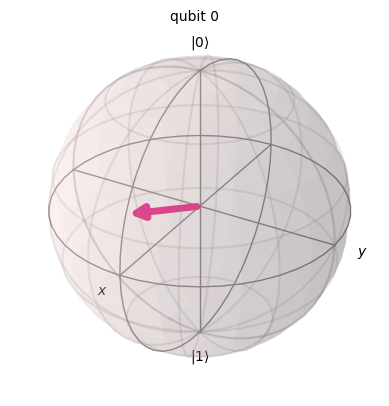

string - total - percentage
0     695    69%
1     305    30%


None

--------------------------------------------------
FALSE_INFO
theta: 1.369438406004566


<IPython.core.display.Latex object>

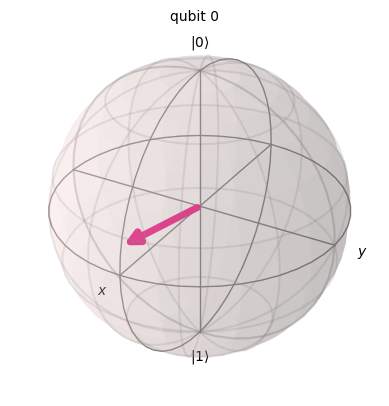

string - total - percentage
0     613    61%
1     387    38%


None

--------------------------------------------------
WANTED
theta: 0.4510268117962625


<IPython.core.display.Latex object>

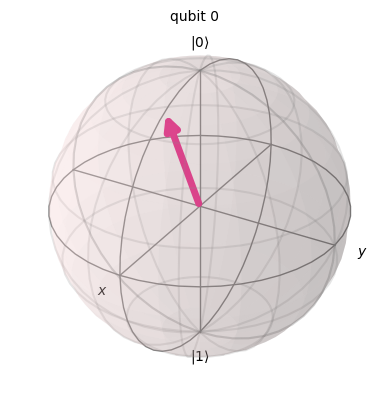

string - total - percentage
0     959    95%
1     41    4%


None

--------------------------------------------------
BRIBE
theta: 0.6435011087932844


<IPython.core.display.Latex object>

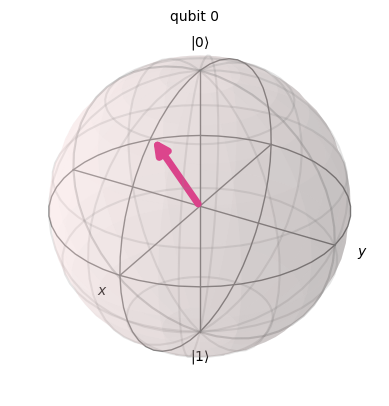

string - total - percentage
0     892    89%
1     108    10%


None

In [17]:
for qubit, theta in list(thetas.items()):
    print('-'*50)
    print(qubit.upper())
    print(f'theta: {theta}')
    
    circuit = QuantumCircuit(1)
    circuit.ry(theta, 0)
    test_probabilities(circuit)

In [43]:
class Inputs:
    def __init__(self, *args, probabilities):
        self.total_qubits = len(args)
        
        assert len(probabilities) == self.total_qubits, "different size between probabilities and qubits array"
        
        self.probabilities = probabilities
        self.circuit = QuantumCircuit(*args)
        
    def prepare(self):
        self.bind_probabilities()
        
    def bind_probabilities(self):
        for qubit, probability in enumerate(self.probabilities):
            self.bin_theta_from_probability(qubit, probability)
    
    def bin_theta_from_probability(self, qubit, probability):
        beta = np.sqrt(probability)/10
        theta = np.arcsin(beta)*2
        self.circuit.ry(theta, qubit)
        
    def show(self):
        display(self.circuit.draw('mpl'))
        
    def add_measurement(self):
        self.circuit.measure_all()
    
    def measure(self, backend=Aer.get_backend("aer_simulator"), shots=1000):
        transpiled_circuit = transpile(self.circuit, backend)
        results = backend.run(transpiled_circuit, shots=shots).result().get_counts()
        display(plot_histogram(results))
        return {'results':results, 'shots':shots}
    
    def get_circuit(self):
        return self.circuit

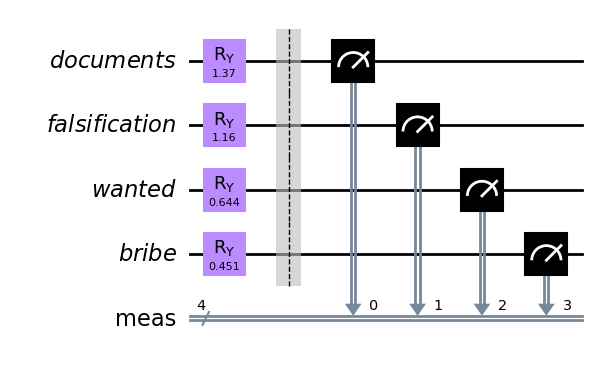

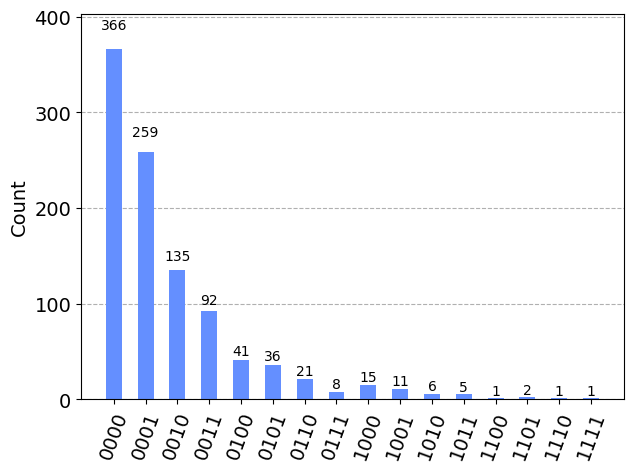

In [44]:
inputs = Inputs(all_documents, false_info, wanted, bribe, probabilities=[40, 30, 10, 5])
inputs.prepare()
inputs.add_measurement()
inputs.show()
results = inputs.measure()

In [20]:
def evaluate_results(shots, qubits, results):
    totals = { qubit:0 for qubit in qubits }
    qubits = qubits[::-1]
    
    for bit_string, total in list(results.items()):
        for qubit, value in enumerate(bit_string):
            if(value == '1'):
                totals[qubits[qubit]] += total
                
    percentages = {}
    for qubit, total in list(totals.items()):
        percentages[qubit] = (total/shots)*100
    print(percentages)
    
evaluate_results(1000, ['all_documents', 'false_info', 'wanted', 'bribe'], results['results'])
    

{'all_documents': 42.0, 'false_info': 30.3, 'wanted': 10.9, 'bribe': 5.0}


---

# Putting all together

In [84]:
class QPP:
    def __init__(self, *args, generator, checker):
        self.generator = generator
        self.checker = checker
        
        phase = AncillaRegister(1, name="ancilla")
        self.output = ClassicalRegister(len(args), name="out")
        self.data_qubits_indexes = list(range(1, len(args)+1))
        
        self.circuit = QuantumCircuit(phase, *args, self.output)
        self.circuit.compose(generator, inplace=True, qubits=self.data_qubits_indexes)
        self.circuit.barrier()
        self.circuit.compose(checker, inplace=True)
    
    def add_measurement(self):
        self.circuit.measure(self.data_qubits_indexes, self.output)
    
    def measure(self, backend=Aer.get_backend("aer_simulator"), shots=1000):
        transpiled_circuit = transpile(self.circuit, backend)
        results = backend.run(transpiled_circuit, shots=shots).result().get_counts()
        display(plot_histogram(results))
        return {'results':results, 'shots':shots}
        
    
    def show(self):
        display(self.circuit.draw('mpl'))

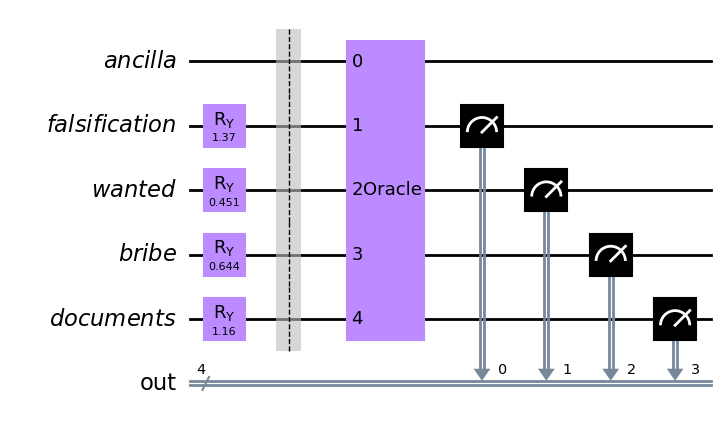

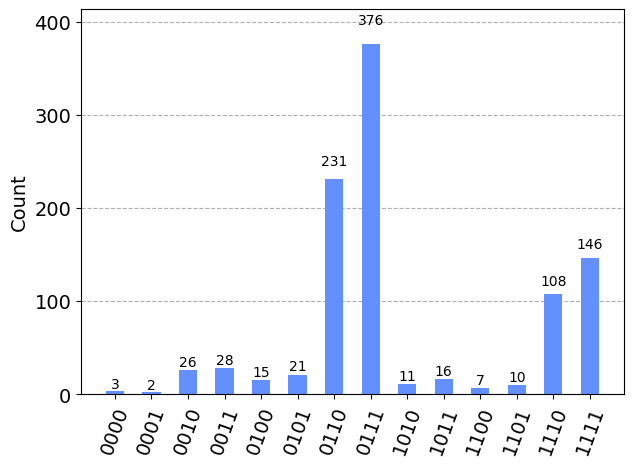

In [94]:
qubits = [false_info, wanted, bribe, all_documents]


inputs = Inputs(*qubits, probabilities=[40, 5, 10, 30])
inputs.prepare()

checker = Check(*qubits)
checker.prepare(bit_string="1000")

algorithm = QPP(*qubits, generator=inputs.get_circuit(), checker=checker.get_circuit())
algorithm.add_measurement()
algorithm.show()
results = algorithm.measure()

In [95]:
evaluate_results(1000, ['false_info', 'wanted', 'bribe', 'all_documents'], results['results'])

{'false_info': 59.9, 'wanted': 94.19999999999999, 'bribe': 91.4, 'all_documents': 29.799999999999997}
